In [1]:
# This notebook implements an autoencoder with 3 hidden layers for both the
# encoder and the decoder and trains it for the MNIST data set.

In [2]:
import collections
import datetime
import json
import math
import random
import time

import cv2
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import pylab
import scipy
import seaborn as sns
import skimage
import sklearn
import statsmodels as sm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

fsize=(20.0, 15.0)
linewidth = 1.0
dotsize = 15

Using TensorFlow backend.


### Build the autoencoder

In [3]:
input_img = keras.layers.Input(shape=(784,))
encoded = keras.layers.Dense(128, activation='relu')(input_img)
encoded = keras.layers.Dense(64, activation='relu')(encoded)
encoded = keras.layers.Dense(32, activation='relu')(encoded)

decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(128, activation='relu')(decoded)
decoded = keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.models.Model(input_img, decoded)

encoder = keras.models.Model(input_img, encoded)

encoded_input = keras.layers.Input(shape=(32,))
decoder_layer_1 = autoencoder.layers[-3]
decoder_layer_2 = autoencoder.layers[-2]
decoder_layer_3 = autoencoder.layers[-1]
decoder = keras.models.Model(encoded_input, decoder_layer_3(decoder_layer_2(decoder_layer_1(encoded_input))))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Prepare the data

In [4]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Training

In [6]:
n_epochs = 100

hist = autoencoder.fit(
            x_train,
            x_train,
            epochs=n_epochs,
            callbacks=[keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.005,
                            patience=10,
                            verbose=0,
                            mode='min')],
            batch_size=256,
            shuffle=True,
            validation_data=(x_test, x_test),
            verbose=0)

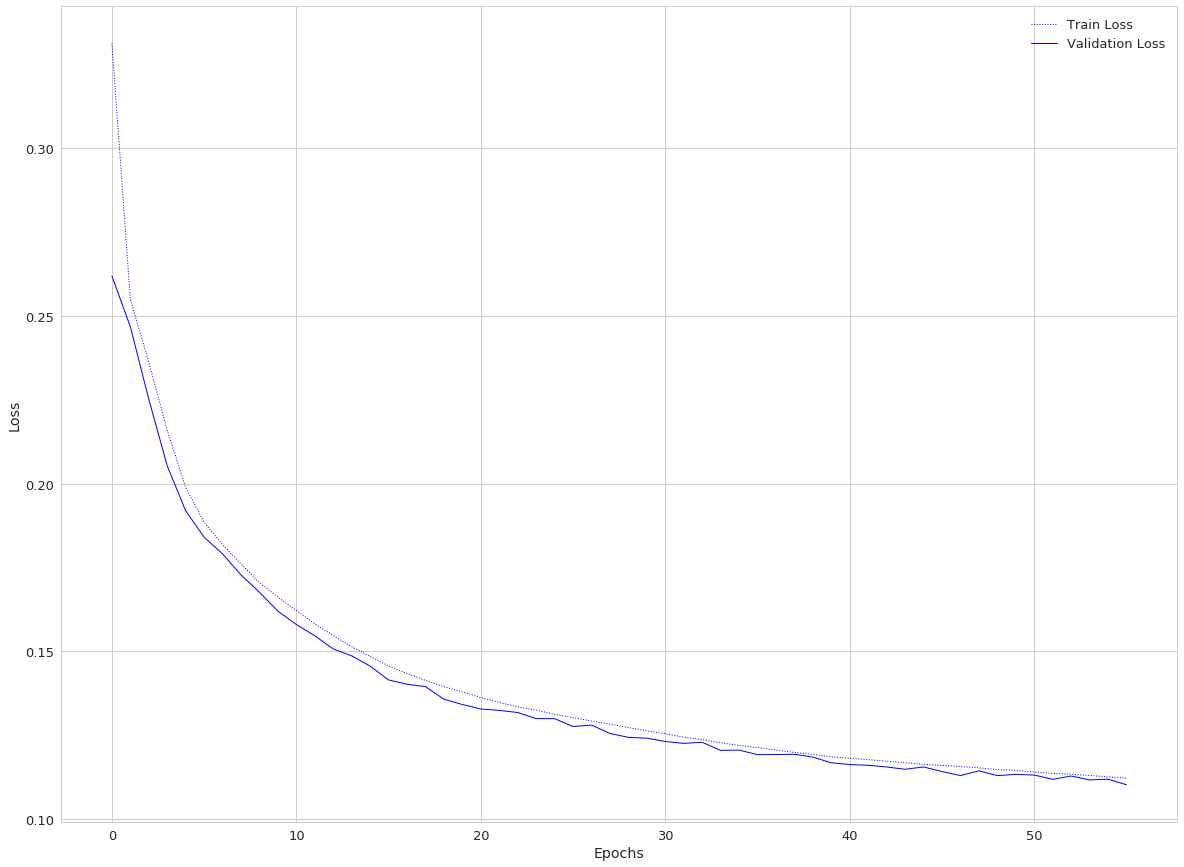

In [7]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

n_eps = range(len(loss))

_ = plt.figure(figsize=fsize)

_ = plt.plot(n_eps, loss, 'b:', label='Train Loss', linewidth=linewidth)
_ = plt.plot(n_eps, val_loss, 'b-', label='Validation Loss', linewidth=linewidth)

_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss')

_ = plt.legend()

### Visualize the results

In [8]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

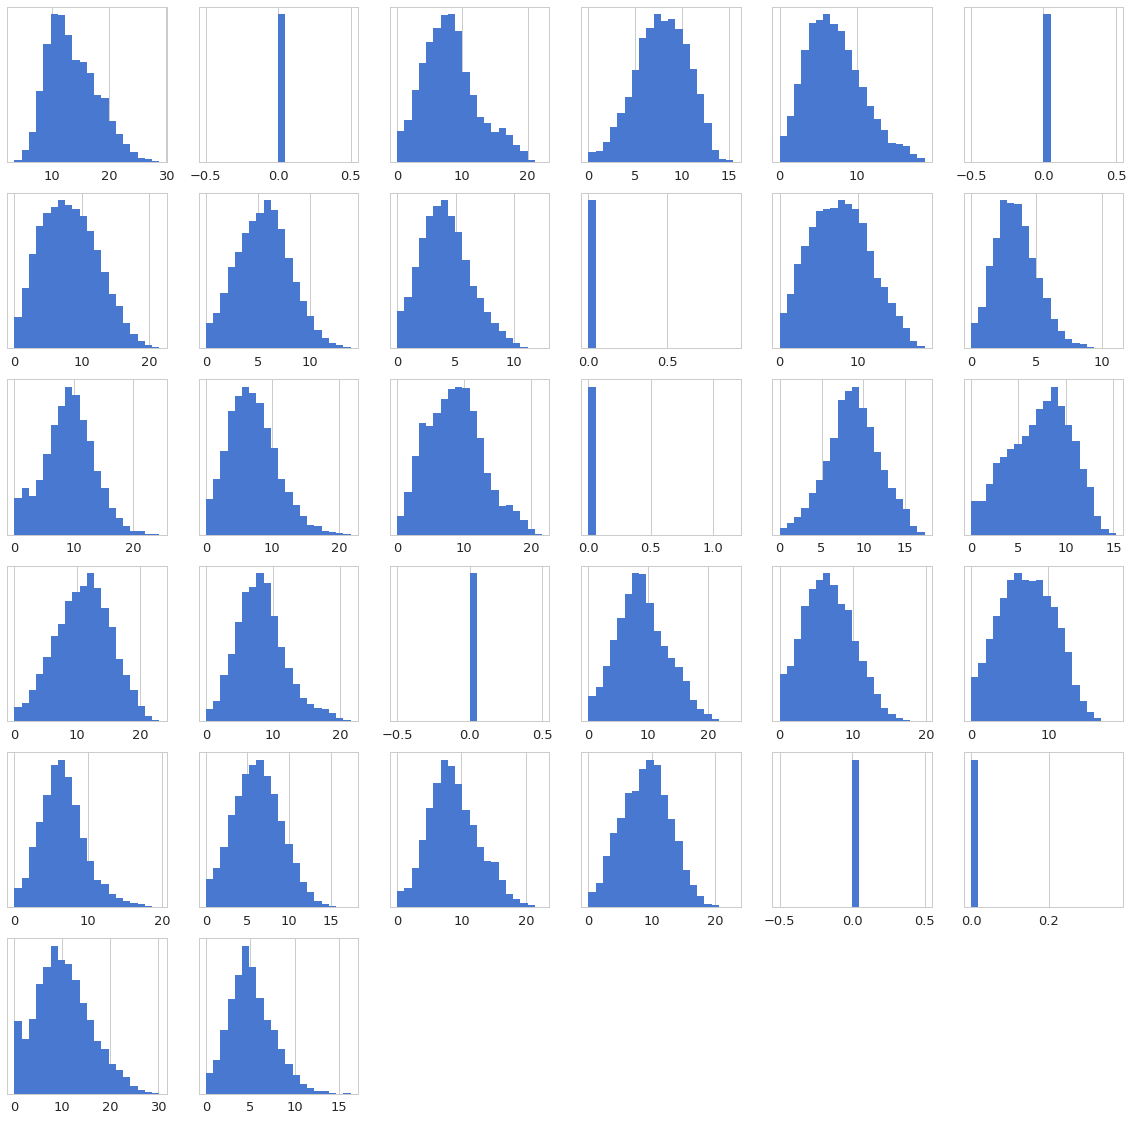

In [9]:
_ = plt.figure(figsize=(20, 20))

for i in range(32):
    ax = plt.subplot(6, 6, i + 1)
    plt.hist(encoded_imgs[:, i], bins=20)
    ax.get_yaxis().set_visible(False)

In [10]:
def display_results(input_imgs, output_imgs, n_results, offset):
    _ = plt.figure(figsize=(20, int(40./n_results)))
    for i in range(n_results):
        ax = plt.subplot(2, n_results, i + 1)
        plt.imshow(input_imgs[offset + i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n_results, i + 1 + n_results)
        plt.imshow(output_imgs[offset + i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

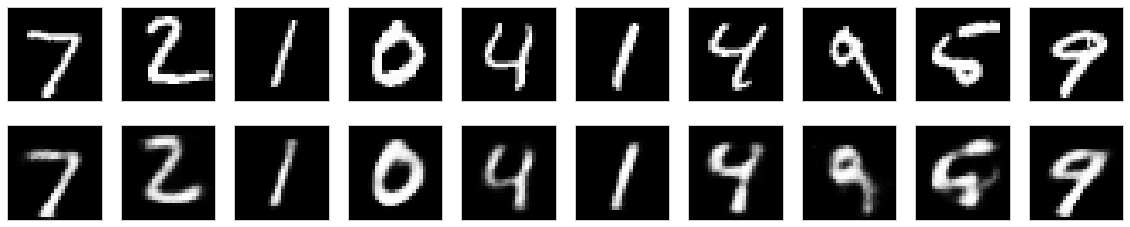

In [11]:
display_results(x_test, decoded_imgs, 10, 0)

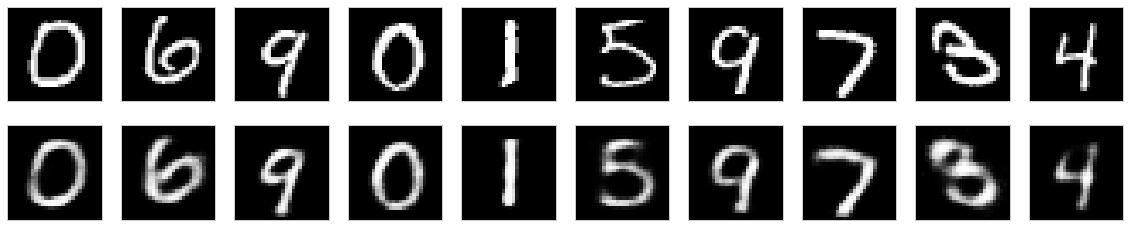

In [12]:
display_results(x_test, decoded_imgs, 10, 10)

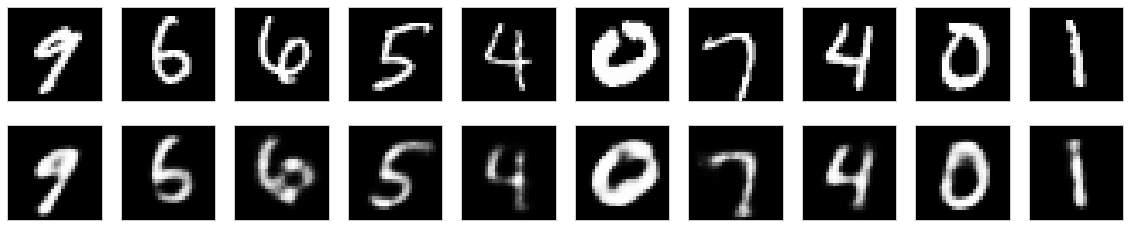

In [13]:
display_results(x_test, decoded_imgs, 10, 20)

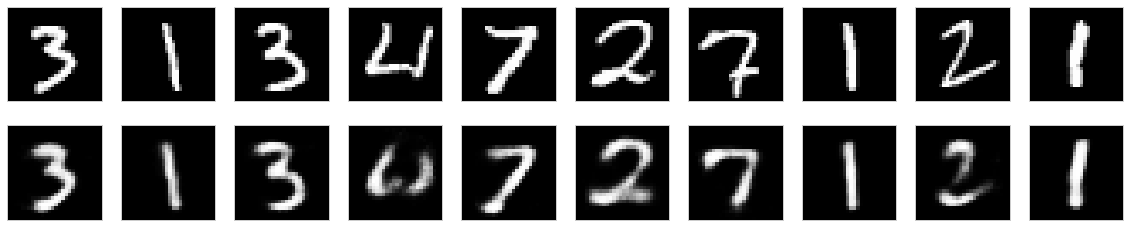

In [14]:
display_results(x_test, decoded_imgs, 10, 30)

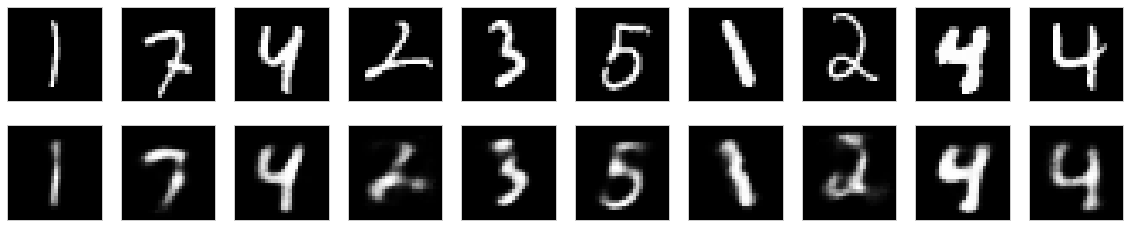

In [15]:
display_results(x_test, decoded_imgs, 10, 40)

### Let's see how it does on different types of images

In [16]:
novel_imgs = np.array([(cv2.imread('../data/ae_0{}.png'.format(i))[:,:,0]).reshape(784)/255. for i in range(10)])
encoded_novel_imgs = encoder.predict(novel_imgs)
decoded_novel_imgs = decoder.predict(encoded_novel_imgs)

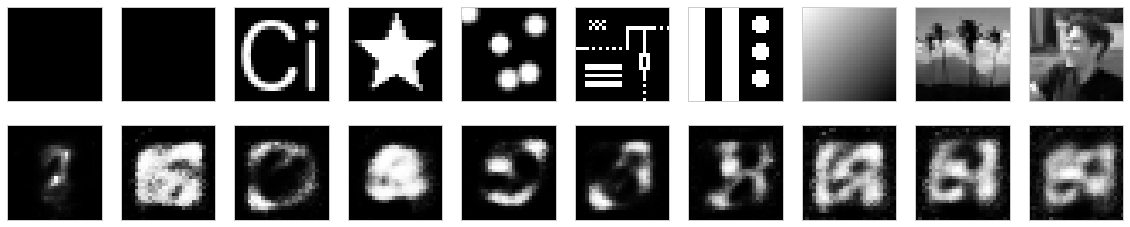

In [17]:
display_results(novel_imgs, decoded_novel_imgs, 10, 0)